In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Hacka')

Mounted at /content/drive


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score

In [ ]:
pd.options.display.float_format = '{:.2f}'.format # Для удобного вывода дробей

# Pro_cntrbtrs.csv

In [ ]:
crs = pd.read_csv('npo_cntrbtrs.csv')

In [ ]:
crs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248947 entries, 0 to 248946
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   npo_accnt_id           248947 non-null  object 
 1   clnt_id                248947 non-null  object 
 2   accnt_pnsn_schm        248866 non-null  float64
 3   slctn_nmbr             248947 non-null  int64  
 4   npo_accnt_status       248947 non-null  int64  
 5   npo_accnt_status_date  248947 non-null  object 
 6   npo_blnc               119305 non-null  float64
 7   npo_pmnts_sum          233181 non-null  float64
 8   npo_pmnts_nmbr         233181 non-null  float64
 9   npo_frst_pmnt_date     233181 non-null  object 
 10  npo_lst_pmnt_date      233181 non-null  object 
 11  npo_ttl_incm           235141 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 22.8+ MB


Удаляем строки, имеющие clnt_id которые сверху, возможно это мульти аккаунты, но как это узнать идей = 0, а если приводит Nan -> 0, то эти id будут выбросами т.к. их значения на пару тысяч больше чем 0)))))

In [ ]:
values_to_remove = [
    "0x7D8BA4FB114F714990ABE509B3874960",
    "0xFF4793102C821C4FA53AF7427202CD12",
    "0x7418F92322DC424CA03149393E6C60F2",
    "0xD2E3933D018E884C84C3CAAC987F5F7B",
    "0xFF85405000F51F4C8B305F5F88857D9B"
]

# Удаляем строки, где clnt_id находится в списке values_to_remove
crs = crs[~crs['clnt_id'].isin(values_to_remove)]

Теперь делит если в 6 строках Nan

In [ ]:
df = crs.copy()

In [ ]:
df = df.dropna(subset=['npo_blnc', 'npo_pmnts_sum', 'npo_pmnts_nmbr', 'npo_frst_pmnt_date', 'npo_lst_pmnt_date', 'npo_ttl_incm'], how='all')

In [ ]:
# Заменяем NaN значения на 0 в столбце "npo_blnc", если "npo_accnt_status" равен 0
df['npo_blnc'] = df.apply(lambda row: 0 if row['npo_accnt_status'] == 0 and pd.isna(row['npo_blnc']) else row['npo_blnc'], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241659 entries, 0 to 248946
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   npo_accnt_id           241659 non-null  object 
 1   clnt_id                241659 non-null  object 
 2   accnt_pnsn_schm        241585 non-null  float64
 3   slctn_nmbr             241659 non-null  int64  
 4   npo_accnt_status       241659 non-null  int64  
 5   npo_accnt_status_date  241659 non-null  object 
 6   npo_blnc               241307 non-null  float64
 7   npo_pmnts_sum          233176 non-null  float64
 8   npo_pmnts_nmbr         233176 non-null  float64
 9   npo_frst_pmnt_date     233176 non-null  object 
 10  npo_lst_pmnt_date      233176 non-null  object 
 11  npo_ttl_incm           235136 non-null  float64
dtypes: float64(5), int64(2), object(5)
memory usage: 24.0+ MB


Ниже код с df не выполнять пока, потому что это заполнение nan, крч в конце делаешь хипишь этот пока чекни cent_50 и вот этот весь код
Всё это про то если интересно, а если нет, то просто выполни 2 строчки которые ниже

In [ ]:
# Удаляем аномальные значения
df = df[df['npo_pmnts_sum'] > 50]
df.loc[(df['npo_blnc'] == df['npo_pmnts_sum']) & (df['npo_ttl_incm'].isna()), 'npo_ttl_incm'] = 0

In [ ]:
df.loc[df['npo_accnt_id'] == '0xA625005056964A2C11ED35BB49D38C38', ['npo_blnc', 'npo_ttl_incm']] = 0

Загружаем файл с транзакциями

In [ ]:
trans = pd.read_csv('npo_trnsctns.csv')

In [ ]:
nan_row = df[df['npo_blnc'].isna()]

In [ ]:
nan_row = nan_row.dropna(subset=['npo_pmnts_sum'])

In [ ]:
nan_income = df[df['npo_ttl_incm'].isna()]

In [ ]:
filtered_table1 = nan_income[nan_income['npo_blnc'] == 0]
zero_blnc = pd.merge(filtered_table1, trans, on='npo_accnt_id', how = 'inner')

In [ ]:
# Группируем данные по 'clnt_id' и вычислите сумму значений 'npo_sum' и 'npo_pmnts_sum'
grouped = zero_blnc.groupby('npo_accnt_id').agg({'npo_sum': 'sum', 'npo_pmnts_sum': 'max'}).reset_index()

# Вычисляем разницу между 'npo_pmnts_sum' и суммой 'npo_sum'
grouped['difference'] = grouped['npo_pmnts_sum'] - grouped['npo_sum']

# Исходный датасет с данными из grouped
zero_blnc = pd.merge(zero_blnc, grouped[['npo_accnt_id', 'difference']], on='npo_accnt_id', how='left')

# Рассчитываем новое значение для 'npo_ttl_incm'
zero_blnc['npo_ttl_incm'] = zero_blnc['difference']

# Удаляем временный столбец 'difference', если не нужен
zero_blnc.drop('difference', axis=1, inplace=True)

In [ ]:
blnc_1 =  nan_income[(nan_income['npo_accnt_status'] == 1) & (nan_income['npo_blnc'] > 0)]

In [ ]:
norm_ac = pd.merge(blnc_1, trans, on='npo_accnt_id', how = 'inner')

In [ ]:
# Группируем данные по 'clnt_id' и вычислите сумму значений 'npo_sum' и 'npo_pmnts_sum'
grouped_2 = norm_ac.groupby('npo_accnt_id').agg({'npo_sum': 'sum', 'npo_pmnts_sum': 'max'}).reset_index()

# Вычисляем разницу между 'npo_pmnts_sum' и суммой 'npo_sum'
grouped_2['difference'] = grouped_2['npo_pmnts_sum'] - grouped_2['npo_sum']

# Исходный датасет с данными из grouped_2
norm_ac = pd.merge(norm_ac, grouped_2[['npo_accnt_id', 'difference']], on='npo_accnt_id', how='left')

# Рассчитываем новое значение для 'npo_ttl_incm'
norm_ac['npo_ttl_incm'] = norm_ac['difference']

# Удаляем временный столбец 'difference', если не нужен
norm_ac.drop('difference', axis=1, inplace=True)

In [ ]:
df.dropna()

# Предобработка npo_clnt с использованием стороннего файла с областями

In [ ]:
index = pd.read_excel('121102_PostIndx.xls')

index.rename(columns={'Наименование области, края, республики' : 'region',
                      'Почтовый индекс объекта почтовой связи' : 'pstl_code_clean'}, inplace=True)
index = index[['pstl_code_clean', 'region']]

In [ ]:
cln = pd.read_csv('npo_clnts.csv')

#удаляем дубликаты в id клиентов
cln = cln.drop_duplicates(subset=['clnt_id'])

#преобразовываем почтовый индекс в число
code=[]
for c in cln['pstl_code']:
  try:
    code.append(int(float(c)))
  except:
    code.append(0)

cln['pstl_code_clean'] = code

#объединаяем клиентов и области по почтовому индексу
result = cln.merge(index, on='pstl_code_clean', how='left')

#проставляем unknown там, где nan в (области) region
result['region'] = result['region'].apply(lambda x: "unknown" if x != x else x)

#ставим 0 в почтовых индексах там, где область unknown,
#чтобы убрать некорректные почтове индексы (такие там есть)
pstl = []
for i in range(result.shape[0]):
  if result.loc[i]['region'] == "unknown":
    pstl.append(0)
  else:
    pstl.append(result.loc[i]['pstl_code_clean'])

clnr = result.drop(columns=['pstl_code_clean'], axis=1)
clnr['pstl_code'] = pstl

In [ ]:
Q1 = df.quantile(0.1)
Q3 = df.quantile(0.9)
IQR = Q3 - Q1

# Определите границы для столбца 'gndr'
lower_bound_gndr = Q1['npo_blnc'] - 1.5 * IQR['npo_blnc']
upper_bound_gndr = Q3['npo_blnc'] + 1.5 * IQR['npo_blnc']

# Удаление выбросов только в столбце 'npo_blnc'
df['npo_blnc'] = df['npo_blnc'].clip(lower=lower_bound_gndr, upper=upper_bound_gndr)

#удаление значений больше Q3 + 1.5 * IQR в npo_pmnts_sum
df = df.loc[df['npo_pmnts_sum'] < Q3['npo_pmnts_sum'] + 1.5 * IQR['npo_pmnts_sum']]

#удаление значений > 500000 в npo_ttl_incm
df = df.loc[df['npo_ttl_incm'] < 500000]

<ipython-input-28-46ba07220576>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = df.quantile(0.1)
<ipython-input-28-46ba07220576>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = df.quantile(0.9)


In [ ]:
from pandas.core.api import DataFrame
from datetime import datetime
#преобразование строк дат в даты
dates = df.filter(like='date', axis=1)

for col in dates.columns:
  df[col] = df[col].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [ ]:
#объединение клиентов и информацию о статусах счетов клиентов НПО (1 и 2 таблицы)
merged = pd.merge(df, clnr, on='clnt_id', how='left')

In [ ]:
#удаляем клиентов с возрастом < 0 и > 200, а также по году рождения старше 1947
merged = merged.loc[(merged['age'] > 0) & (merged['age'] < 200)]
merged = merged.loc[merged['brth_yr'] > 1947]

# Объединение

In [ ]:
df_new = pd.merge(merged, trans, on='npo_accnt_id', how='left')

In [ ]:
df_new = df_new[df_new['npo_blnc'] >= 0]

In [ ]:
# Создаём новый датафрейм с выплатами
negative_values_df = df_new[df_new['npo_sum'] < 0]

In [ ]:
# Нет времени

# trans['npo_operation_date'] = pd.to_datetime(trans['npo_operation_date'])

# def get_inflation(row):
#     year = row['npo_operation_date'].year
#     month = row['npo_operation_date'].month
#     inflation_value = inf.loc[year, month]
#     return inflation_value

# trans['infl_rate'] = trans.apply(get_inflation, axis=1)

In [ ]:
# Нет ресурсов

# # Проверить, есть ли дата операции в файле с инфляцией и вычислить увеличение суммы с учетом инфляции
# def calculate_inflation(row):
#     operation_date = row['npo_operation_date']
#     inflation_data = inf[inf['год'] <= 2022]  # Фильтруем данные инфляции до 2022 года
#     inflation_rate = inflation_data['годовая инфляция'].mean()  # Средняя инфляция до 2022 года
#     years_passed = 2022 - operation_date.year
#     inflation_multiplier = (1 + inflation_rate) ** years_passed
#     return row['npo_sum'] * inflation_multiplier

# # Применить функцию к столбцу npo_sum в датафрейме с операциями
# df_new['npo_sum'] = df_new.apply(calculate_inflation, axis=1)

# Началось построение модели

In [ ]:
# Преобразуем 'npo_operation_date' в формат даты, если он ещё не преобразован
df_new['npo_operation_date'] = pd.to_datetime(df_new['npo_operation_date'])

In [ ]:
# Уберём выбросы по зачислениям на счета

Q1 = df_new['npo_sum'].quantile(0.15)
Q3 = df_new['npo_sum'].quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_new[(df_new['npo_sum'] >= lower_bound) & (df_new['npo_sum'] <= upper_bound)]

In [ ]:
df_cleaned = df_cleaned.sort_values(by='npo_operation_date')

In [ ]:
# Создаём временной ряд с суммами взносов
time_series = df_cleaned.set_index('npo_operation_date')['npo_sum']

In [ ]:
# Определяем разницу между текущим значением и значением год назад
dif_1 = time_series - time_series.shift(12)

# Определяем разницу между полученным значением и смещенным на 1 месяц назад значением
dif_2 = dif_1 - dif_1.shift(1)

# Удаляем пропущенные значения, которые появляются после дифференцирования
time_series_new = dif_2.dropna()

# Ресемплируем временной ряд на месяцы
Q_resampled = time_series_new.resample('Q').sum()

# Разделите временной ряд на обучающий и тестовый наборы
train_data = Q_resampled[:-16]  # Данные для обучения до последних 4 лет
test_data = Q_resampled[-16:]   # Последние 4 года - для тестирования

In [ ]:
# Фактические значения для тестового набора
actual_values = test_data.values

# SARIMAX

In [ ]:
#Greed Search для гипер параметров SARIMAX

# import itertools
# from statsmodels.tsa.statespace.sarimax import SARIMAX

# def grid_search_sarima(data, seasonal_periods=12, p_range=(0, 4), d_range=(0, 4), q_range=(0, 4),
#                        P_range=(0, 4), D_range=(0, 4), Q_range=(0, 4)):
#     best_aic = float("inf")
#     best_params = None

#     for p, d, q in itertools.product(range(p_range[0], p_range[1] + 1),
#                                      range(d_range[0], d_range[1] + 1),
#                                      range(q_range[0], q_range[1] + 1)):
#         for P, D, Q in itertools.product(range(P_range[0], P_range[1] + 1),
#                                          range(D_range[0], D_range[1] + 1),
#                                          range(Q_range[0], Q_range[1] + 1)):
#             try:
#                 model = SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, seasonal_periods))
#                 results = model.fit()
#                 aic = results.aic
#                 if aic < best_aic:
#                     best_aic = aic
#                     best_params = (p, d, q, P, D, Q)
#             except:
#                 continue

#     return best_params, best_aic

# # Использование функции grid_search_sarima
# best_params, best_aic = grid_search_sarima(train_data)
# print("Лучшие параметры:", best_params)
# print("Лучший AIC:", best_aic)

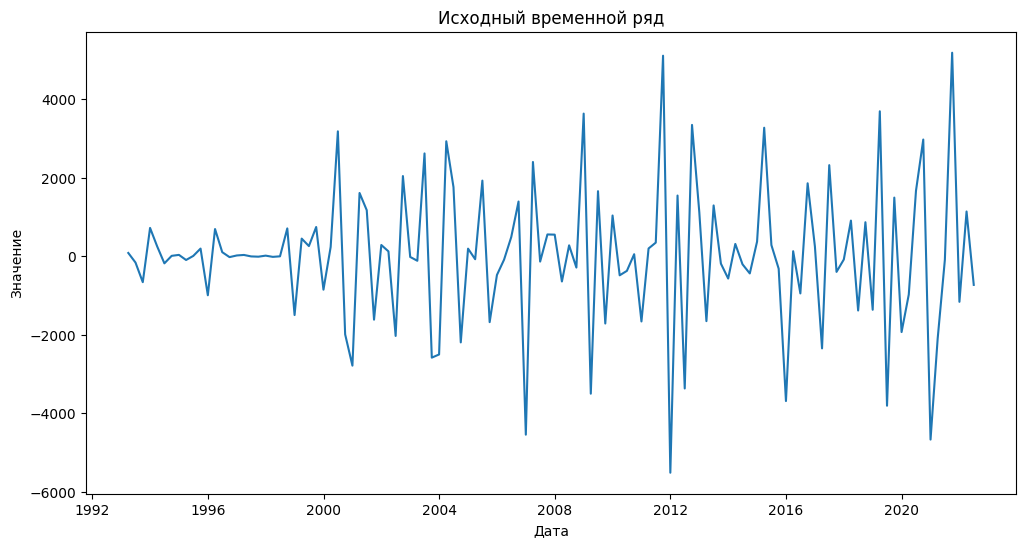

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


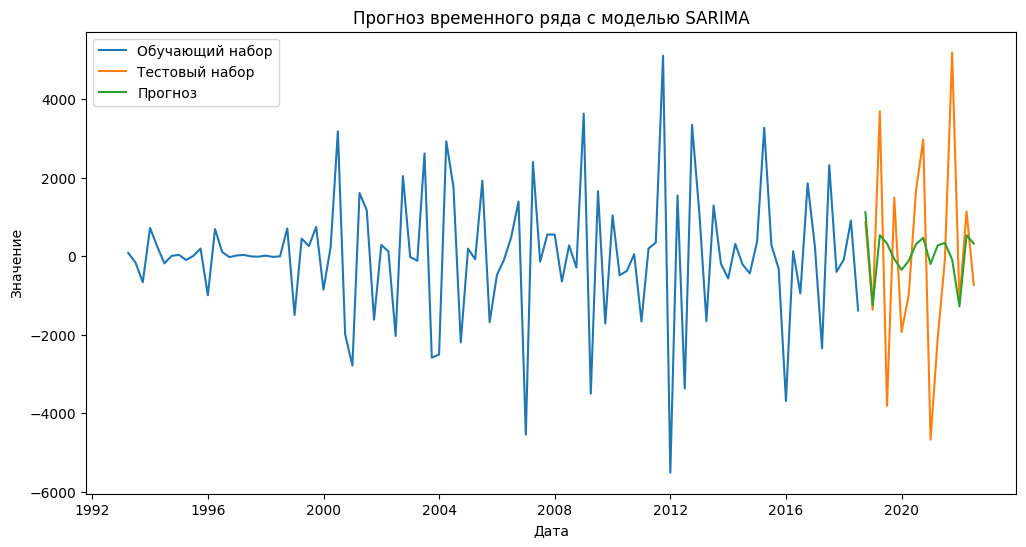

In [ ]:
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(Q_resampled)
plt.title('Исходный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# Обучение модели SARIMAX
p = 1  # Параметр ARIMA
d = 1  # Параметр разности
q = 2  # Параметр скользящего среднего
P = 0  # Параметр сезонной составляющей ARIMA
D = 1  # Параметр сезонной разности
Q = 1  # Параметр сезонного скользящего среднего
S = 12  # Период сезонности (если у вас месячные данные, то S=12)

order = (p, d, q)              # Параметры ARIMA
seasonal_order = (P, D, Q, S)  # Параметры сезонности SARIMA
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=0)

# Прогнозирование
forecast_values = model_fit.forecast(steps=16)  # Прогноз на следующие 48 месяцев

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Обучающий набор')
plt.plot(test_data, label='Тестовый набор')
plt.plot(test_data.index, forecast_values, label='Прогноз')
plt.title('Прогноз временного ряда с моделью SARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

Нижнее если не разделять на положительные и отрицательные, но по-моему лучше сделать 2 отдельных модели для income и pension

In [ ]:
# Вычисление абсолютных различий
absolute_errors = np.abs(actual_values - forecast_values)
# Вычисление средней абсолютной ошибки (MAE)
mae = np.mean(absolute_errors)
print(f"Средняя абсолютная ошибка (MAE): {mae}")

Средняя абсолютная ошибка (MAE): 1865.4108325449101


In [ ]:
# Вычисление R2
r2 = r2_score(actual_values, forecast_values)

print("R2:", r2)

R2: 0.09059376826564836


Прогнозирование на тестовых данных

In [ ]:
trans_test = pd.read_csv('npo_trnsctns_test.csv')

In [ ]:
trans_test.dropna()

In [ ]:
trans_test['npo_operation_date'] = pd.to_datetime(trans_test['npo_operation_date'])
pre_time = trans_test.sort_values(by='npo_operation_date')
test_data = df_cleaned.set_index('npo_operation_date')['npo_sum']

In [ ]:
quarterly_sum = test_data.resample('Q').sum()

In [ ]:
# Вычисление абсолютных различий
absolute_errors_test = np.abs(quarterly_sum - forecast_values)
# Вычисление средней абсолютной ошибки (MAE)
mae_test = np.mean(absolute_errors_test)
print(f"Средняя абсолютная ошибка (MAE): {mae_test}")

Средняя абсолютная ошибка (MAE): 17440.68405158466


In [ ]:
common_dates = forecast_values.index.intersection(quarterly_sum.index)
forecast_values_common = forecast_values.loc[common_dates]
quarterly_sum_common = quarterly_sum.loc[common_dates]

# R2-коэффициент детерминации для сравнения рядов
r2 = r2_score(forecast_values_common, quarterly_sum_common)

print("R2:", r2)

R2: -46.69693667590303


# Выплаты SARIMA

In [ ]:
# # Создаём новый датафрейм с выплатами
# negative_values_df = df_new[df_new['npo_sum'] < 0]

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Преобразуем 'npo_operation_date' в формат даты, если он ещё не преобразован
negative_values_df['npo_operation_date'] = pd.to_datetime(negative_values_df['npo_operation_date'])

<ipython-input-124-bca7ab1e45f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_values_df['npo_operation_date'] = pd.to_datetime(negative_values_df['npo_operation_date'])


In [ ]:
# Уберём выбросы по выплатам

Q1 = negative_values_df['npo_sum'].quantile(0.15)
Q3 = negative_values_df['npo_sum'].quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = negative_values_df[(df_new['npo_sum'] >= lower_bound) & (negative_values_df['npo_sum'] <= upper_bound)]

<ipython-input-125-1a6332c39629>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned = negative_values_df[(df_new['npo_sum'] >= lower_bound) & (negative_values_df['npo_sum'] <= upper_bound)]


In [ ]:
# Создаём временной ряд с суммами выплат
time_series_m = negative_values_df.set_index('npo_operation_date')['npo_sum']

In [ ]:
# Ресемплируем временной ряд на кварталы
Q_resampled_m = time_series_m.resample('Q').sum()

# Разделите временной ряд на обучающий и тестовый наборы
train_data_m = Q_resampled_m[:-16]  # Данные для обучения до последних 4 лет
test_data_m = Q_resampled_m[-16:]   # Последние 4 года - для тестирования

In [ ]:
# Фактические значения для тестового набора для удобства
actual_values_m = test_data_m.values

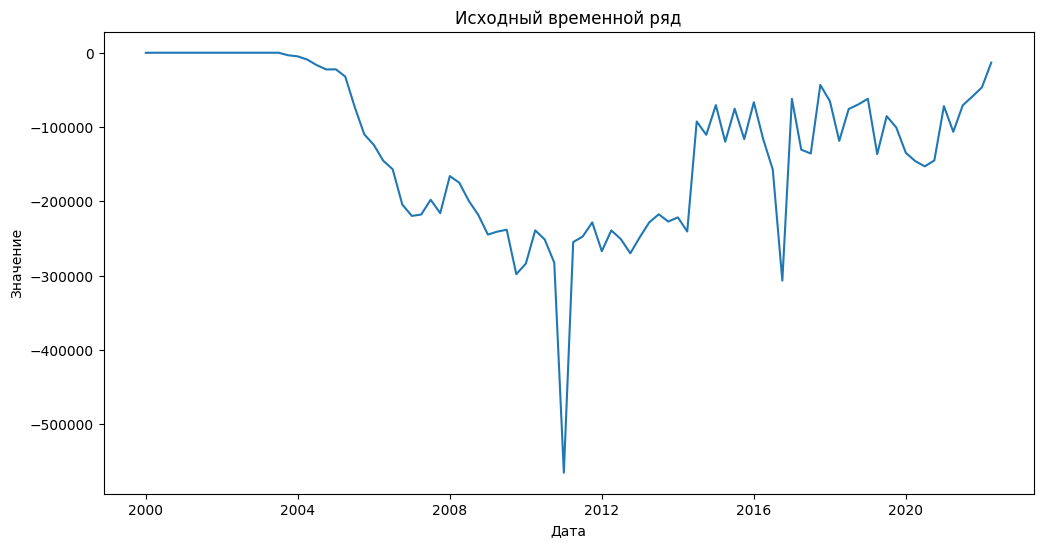

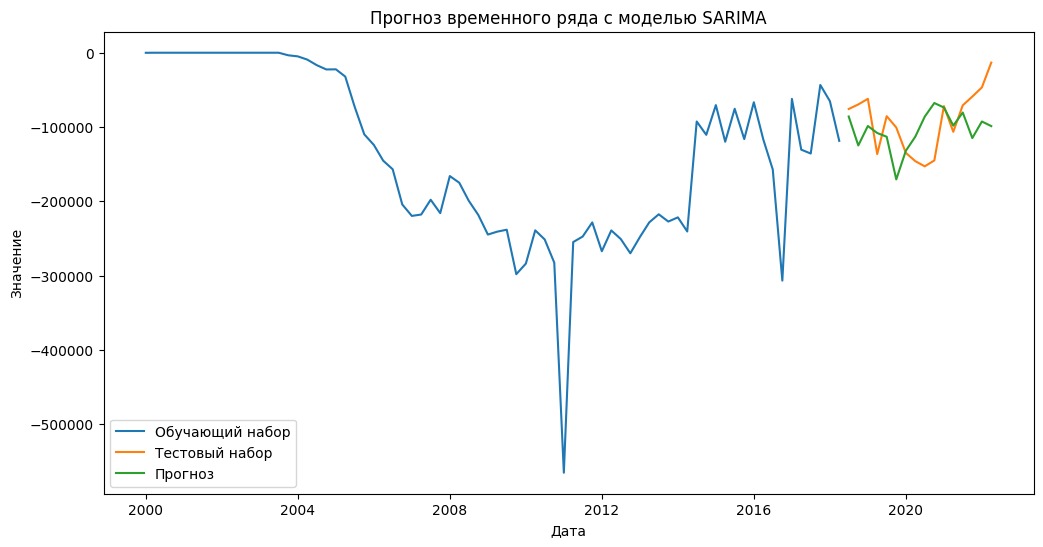

In [ ]:
# Визуализация временного ряда
plt.figure(figsize=(12, 6))
plt.plot(Q_resampled_m)
plt.title('Исходный временной ряд')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

# Обучение модели SARIMA (Было решено взять те же параметры что и у первой модели)
p = 1  # Параметр ARIMA
d = 1  # Параметр разности
q = 2  # Параметр скользящего среднего
P = 0  # Параметр сезонной составляющей ARIMA
D = 1  # Параметр сезонной разности
Q = 1  # Параметр сезонного скользящего среднего
S = 12  # Период сезонности (если у вас месячные данные, то S=12)

order = (p, d, q)              # Параметры ARIMA
seasonal_order = (P, D, Q, S)  # Параметры сезонности SARIMA
model_m = SARIMAX(train_data_m, order=order, seasonal_order=seasonal_order)
model_fit_m = model_m.fit(disp=0)

# Прогнозирование
forecast_values_m = model_fit_m.forecast(steps=16)  # Прогноз на следующие 48 месяцев

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(train_data_m, label='Обучающий набор')
plt.plot(test_data_m, label='Тестовый набор')
plt.plot(test_data_m.index, forecast_values_m, label='Прогноз')
plt.title('Прогноз временного ряда с моделью SARIMA')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [ ]:
# Вычисление R2
r2_m = r2_score(actual_values_m, forecast_values_m)

print("R2:", r2_m)

R2: -0.38463775584872995


In [ ]:
# Вычисление абсолютных различий
absolute_errors_m = np.abs(actual_values_m - forecast_values_m)
# Вычисление средней абсолютной ошибки (MAE)
mae = np.mean(absolute_errors_m)
print(f"Средняя абсолютная ошибка (MAE): {mae_m}")

Средняя абсолютная ошибка (MAE): 38439.84361019275


Прогнозирование на тестовых данных

In [ ]:
trans_test['npo_operation_date'] = pd.to_datetime(trans_test['npo_operation_date'])
pre_time_m = trans_test.sort_values(by='npo_operation_date')
df_big = trans_test[trans_test['npo_sum'] < 0]
test_data_m = df_big.set_index('npo_operation_date')['npo_sum']

In [ ]:
quarterly_sum_m = test_data_m.resample('Q').sum()

In [ ]:
# Вычисление абсолютных различий
absolute_errors_mt = np.abs(quarterly_sum_m - forecast_values_m)
# Вычисление средней абсолютной ошибки (MAE)
mae_mt = np.mean(absolute_errors_mt)
print(f"Средняя абсолютная ошибка (MAE): {mae_mt}")

Средняя абсолютная ошибка (MAE): 52896.12753894157


In [ ]:
common_dates_m = forecast_values_m.index.intersection(quarterly_sum_m.index)
forecast_values_m_common = forecast_values_m.loc[common_dates_m]
quarterly_sum_m_common = quarterly_sum_m.loc[common_dates_m]

# R2-коэффициент детерминации для сравнения рядов
r2_mt = r2_score(forecast_values_m_common, quarterly_sum_m_common)

print("R2:", r2_mt)

R2: -4.394195999832751
